In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示符号
import datetime

In [148]:
new_cg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 4020503 to 2902180
Data columns (total 28 columns):
new_lp_id                           864 non-null int64
new_lp_id                           864 non-null object
new_tl                              864 non-null object
new_mgr                             864 non-null object
life_cycle                          864 non-null object
oct                                 864 non-null float64
Aug                                 864 non-null float64
Sep                                 864 non-null float64
has_expired                         864 non-null float64
s.birthday                          864 non-null datetime64[ns]
s.last_fin_as_major_class_lesson    864 non-null object
s.change_lp_times                   864 non-null float64
s.real_paid_date                    864 non-null datetime64[ns]
s.first_order_stage_type            864 non-null object
old_lp_id                           864 non-null float64
old_lp_name             

In [154]:
new_cg_df.to_csv('WH_students_all.csv')

In [11]:
# 读取学生，重命名新架构
new_cg_df = pd.read_csv('WH_students.csv', encoding='gbk')
new_cg_df.rename(columns={'lp_id': 'new_lp_id', 'tl': 'new_tl', 'mgr': 'new_mgr', 'lp': 'new_lp_id'}, inplace=True)
new_cg_df.set_index('student_id', inplace=True)

In [12]:
# 匹配各个月课消，并且填充0课消
# 读取各个月的课消表
WH_COURSE_SPEND = 'WH_students_course_spend_'
course_spend_list = []
for i in [f'{WH_COURSE_SPEND}10.csv', f'{WH_COURSE_SPEND}8.csv', f'{WH_COURSE_SPEND}9.csv']:
    temp_course_spend_df = pd.read_csv(i).set_index('id')
    new_cg_df = pd.merge(new_cg_df, temp_course_spend_df, how='left',
                              right_index=True, left_index=True).fillna(0)

In [21]:
# 匹配有无有效期
expired_df = pd.read_csv('WH_students_expired.csv').dropna().set_index('opd.student_id')
expired_df['has_expired'] = 1
new_cg_df = pd.merge(new_cg_df, expired_df['has_expired'], how='left',
                              right_index=True, left_index=True).fillna(0)

In [33]:
# 匹配学生原始架构，重命名原始架构
old_cg = pd.read_csv('WH_students_info_o.csv')
old_cg = old_cg.rename(columns={'cg.staff_id': 'old_lp_id', 'cg.staff_name': 'old_lp_name',
                      'cg.tl_master_id': 'old_tl_id', 'cg.mgr_master_name': 'old_mgr'},
              ).set_index('s.student_id')

In [38]:
new_cg_df = new_cg_df.merge(old_cg, how='left', right_index=True, left_index=True)

In [48]:
print('8月平均课消：', new_cg_df['Aug'].mean())
print('9月平均课消：',  new_cg_df['Sep'].mean())
print('10月平均课消：', new_cg_df['oct'].mean())
print('3月平均课消',
      (new_cg_df['oct'].sum() + new_cg_df['Sep'].sum() + new_cg_df['Aug'].sum())/(len(new_cg_df['oct'])*3))

8月平均课消： 5.939814814814815
9月平均课消： 5.568287037037037
10月平均课消： 5.780092592592593
3月平均课消 5.762731481481482


In [50]:
students_num = new_cg_df.shape[0]
print('8月沉睡率：', len(new_cg_df[new_cg_df['Aug']==0])/students_num)
print('9月沉睡率：', len(new_cg_df[new_cg_df['Sep']==0])/students_num)
print('10月沉睡率：', len(new_cg_df[new_cg_df['oct']==0])/students_num)
print('3月总沉睡率',
      len(new_cg_df[(new_cg_df['Aug']==0)&(new_cg_df['Sep']==0)&(new_cg_df['oct']==0)])/students_num)

8月沉睡率： 0.22453703703703703
9月沉睡率： 0.18981481481481483
10月沉睡率： 0.19212962962962962
3月总沉睡率 0.09375


In [83]:
print('无有效期占比', 1 - new_cg_df['has_expired'].sum()/new_cg_df.shape[0])

无有效期占比 0.2442129629629629


In [52]:
def find_level(last_serial_number):
    try:
        level = last_serial_number[4:5]
        if level == '':
            level = 0
        else:
            level = int(level)
        return level
    except TypeError:
        return 0

In [55]:
new_cg_df['level'] = new_cg_df['s.last_fin_as_major_class_lesson'].apply(find_level)

In [59]:
def __cal_learn_month_range(confirm_date):
    learn_month_list = ['<1'] + [f'{i}~{i + 1}' for i in range(1, 12)] + ['>12']
    """
    用来计算学龄的标签 一共分为13个标签，一年以内的一个月一个月，一年以上的占一个列
    :rtype: ''
    """
    days = (datetime.datetime.now() - confirm_date).days
    try:
        return learn_month_list[days // 30]
    except IndexError:
        return learn_month_list[-1]

In [60]:
# 计算学龄月
new_cg_df['s.real_paid_date'] = new_cg_df['s.real_paid_date'].astype('datetime64')
new_cg_df['learn_month'] = new_cg_df['s.real_paid_date'].apply(__cal_learn_month_range)

In [78]:
# 计算各个月总通话时长
call_df = pd.read_csv('WH_students_call_info.csv')
call_df['_c1'] = call_df['_c1'].astype('datetime64')
Aug_call_len_df = call_df[(call_df['_c1'] < '2019-09-01')&(call_df['_c1'] >= '2019-08-01')][['f.student_id', 'c.talk_time_len']].rename(columns={'c.talk_time_len': 'Aug_talk_len'}).groupby(['f.student_id']).sum()
Sep_call_len_df = call_df[(call_df['_c1'] < '2019-10-01')&(call_df['_c1'] >= '2019-09-01')][['f.student_id', 'c.talk_time_len']].rename(columns={'c.talk_time_len': 'Sep_talk_len'}).groupby(['f.student_id']).sum()
Oct_call_len_df = call_df[(call_df['_c1'] < '2019-11-01')&(call_df['_c1'] >= '2019-10-01')][['f.student_id', 'c.talk_time_len']].rename(columns={'c.talk_time_len': 'oct_talk_len'}).groupby(['f.student_id']).sum()
for i in [Aug_call_len_df, Sep_call_len_df, Oct_call_len_df]:
    new_cg_df = new_cg_df.merge(i, how='left', right_index=True, left_index=True)

In [99]:
# 计算年龄
def cal_age(birthday):
#     print(round(((datetime.datetime.now() - birthday).days)/365))
    try:
        return round(((datetime.datetime.now() - birthday).days)/365)
    except:
        return 0

In [100]:
new_cg_df['s.birthday'] = new_cg_df['s.birthday'].astype('datetime64')
new_cg_df['age'] = new_cg_df['s.birthday'].apply(cal_age)

In [119]:
new_cg_df['all_talk_len'] = new_cg_df['Aug_talk_len'] + new_cg_df['Sep_talk_len'] + new_cg_df['oct_talk_len']

In [123]:
for i in ['all_talk_len', 'Aug_talk_len', 'Sep_talk_len', 'oct_talk_len']:
    new_cg_df[i] = new_cg_df[i]//60

In [125]:
new_cg_df['all_has_talk'] = new_cg_df['all_talk_len'].apply(lambda x: 0 if x==0 else 1)

In [149]:
new_cg_df.loc[(new_cg_df['Aug']==0)&(new_cg_df['Sep']==0)&(new_cg_df['oct']==0), 'is_all_sleep'] = 1
new_cg_df.fillna(0, inplace=True)

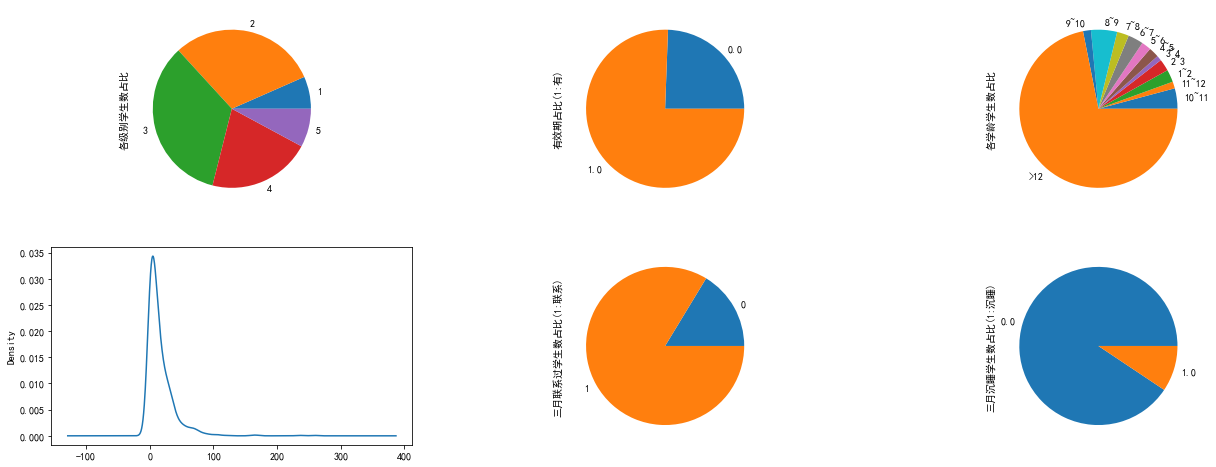

In [153]:
fig, axes = plt.subplots(2, 3)
# new_cg_df[['age', 'old_tl_id']].groupby('age').count().rename(
#     columns={'old_tl_id': '各年龄学生数占比'}).plot.pie(y='各年龄学生数占比', ax=axes[1, 2], legend=False)
new_cg_df[['level', 'old_tl_id']].groupby('level').count().rename(
    columns={'old_tl_id': '各级别学生数占比'}).plot.pie(y='各级别学生数占比', ax=axes[0, 0], figsize=(22, 8),legend=False)
new_cg_df[['has_expired', 'old_tl_id']].groupby('has_expired').count().rename(
    columns={'old_tl_id': '有效期占比(1:有)'}).plot.pie(y='有效期占比(1:有)', ax=axes[0, 1], figsize=(22, 8),legend=False)
new_cg_df[['learn_month', 'old_tl_id']].groupby('learn_month').count().rename(
    columns={'old_tl_id': '各学龄学生数占比'}).plot.pie(y='各学龄学生数占比', ax=axes[0, 2], figsize=(22, 8),legend=False)
new_cg_df[['is_all_sleep', 'old_tl_id']].groupby('is_all_sleep').count().rename(
    columns={'old_tl_id': '三月沉睡学生数占比(1:沉睡)'}).plot.pie(y='三月沉睡学生数占比(1:沉睡)', ax=axes[1, 2], figsize=(22, 8),legend=False)
new_cg_df[['all_has_talk', 'old_tl_id']].groupby('all_has_talk').count().rename(
    columns={'old_tl_id': '三月联系过学生数占比(1:联系)'}).plot.pie(y='三月联系过学生数占比(1:联系)', ax=axes[1, 1], figsize=(22, 8),legend=False)
new_cg_df['all_talk_len'].plot.kde(ax=axes[1, 0], figsize=(22, 8))

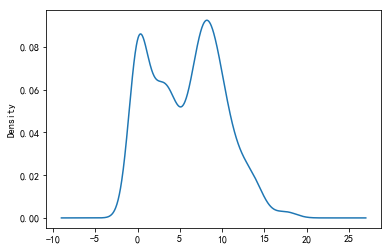

In [139]:
new_cg_df['oct'].plot.kde()

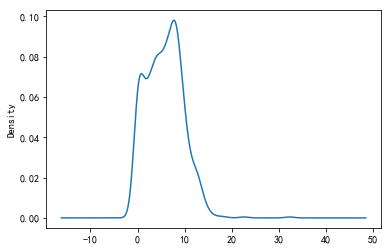

In [143]:
new_cg_df['all_course_spend'].plot.kde()

In [142]:
new_cg_df['all_course_spend'] = (new_cg_df['oct'] + new_cg_df['Aug'] + new_cg_df['Sep'])/3